In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as functional
from torch.optim import SGD
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from sklearn.datasets import fetch_openml
import math

np.random.seed(420)

# Load dataset

In [5]:
import torch.utils
import torchvision
import torchvision.transforms as transforms

torch_enabled = False
train_images = 0
test_images = 0
train_labels = 0
test_labels = 0
trainloader = 0

def load_ds(name, num_test, shape=None):
    """
    fetch dataset from openML.org and split to train/test
    @param name - ID on openML (eg. 'mnist_784')
    @param num_test - num. samples to take as test
    @param shape - new reshape of a single data point (ie data['data'][0]) as a list. Eg. [28,28] for MNIST
    """
    data = fetch_openml(name, version=1, data_home='./data', cache=True)
    sz=data['target'].shape[0]

    X = data['data']
    if shape is not None:
        new_shape = shape.insert(0, sz)
        X = np.reshape(X, new_shape)

    y = data['target'].astype(np.int32)
    # split to train/test data
    train_labels = y[:sz-num_test]
    train_images = X[:sz-num_test]
    test_labels  = y[sz-num_test:]
    test_images  = X[sz-num_test:]

    return train_labels, train_images, test_labels, test_images


def shuffle_data(x, y):
    indices = np.arange(len(y))
    np.random.shuffle(indices)
    x, y = np.array(x), np.array(y)
    return x[indices], y[indices]


def plot_flatten_image(flatten_image, image_height=28):
    plt.imshow(flatten_image.reshape((image_height, -1)))


def to_binary_flatten_images(images):
    n_samples = images.shape[0]
    # flatten every image to vector
    images = images.reshape((n_samples, -1))
    # binary encoding: each image pixel is encoded either 0 or 1 depending on that image mean value
    images = (images >= images.mean(axis=1, keepdims=True)).astype(np.int8)
    return images


backprop_errors = []

In [6]:
if torch_enabled:
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5,), (0.5,))]
    )

    trainset = torchvision.datasets.MNIST(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )
    trainloader = torch.utils.data.DataLoader(
        trainset,
        batch_size=4,
        shuffle=False,
        num_workers=2
    )
    testset = torchvision.datasets.MNIST(
        root='./data',
        train=False,
        download=True,
        transform=transform
    )
    testloader = torch.utils.data.DataLoader(
        testset,
        batch_size=4,
        shuffle=False,
        num_workers=2
    )
else:
    train_labels, train_images, test_labels, test_images = load_ds('mnist_784', 10000, shape=[28,28])

    np.random.seed(42)
    train_images, train_labels = shuffle_data(train_images, train_labels)
    test_images, test_labels = shuffle_data(test_images, test_labels)

    n_train_samples = train_images.shape[0]
    n_test_samples = test_images.shape[0]
    image_shape = train_images[0].shape
    image_side = image_shape[0]
    image_size = image_side ** 2
    train_images = to_binary_flatten_images(train_images)
    test_images = to_binary_flatten_images(test_images)
    plot_flatten_image(train_images[0])
    print('numpy DS loaded')

NameError: name 'fetch_openml' is not defined

In [4]:
train_labels[0]

7

# Torch convolutional net (now unused)

In [3]:
class Conv2Lin2Net(nn.Module):
    c1 = 6
    c2 = 16
    ker_sz = 5
    ker = (ker_sz, ker_sz)
    pooling_square_side = 2
    linear_hidden_sz = 1200

    def __init__(self, image_side, number_of_classes):
        c1 = self.c1
        c2 = self.c2
        ker_sz = self.ker_sz
        ker = self.ker
        pooling_square_side = self.pooling_square_side
        linear_hidden_sz = self.linear_hidden_sz

        self.image_side = image_side
        self.number_of_classes = number_of_classes
        self.linear_layer_input = c2 * (((image_side - ker_sz + 1) // pooling_square_side - ker_sz + 1) // pooling_square_side) ** 2

        super(Conv2Lin2Net, self).__init__()
        self.conv1 = nn.Conv2d(1, c1, ker)
        self.pool = nn.MaxPool2d(pooling_square_side, pooling_square_side)
        self.conv2 = nn.Conv2d(c1, c2, ker)
        self.full_connected1 = nn.Linear(self.linear_layer_input, linear_hidden_sz)
        self.full_connected2 = nn.Linear(linear_hidden_sz, number_of_classes)

    def forward(self, x: torch.tensor) -> np.ndarray:
        x = self.pool(functional.relu(self.conv1(x)))
        x = self.pool(functional.relu(self.conv2(x)))
        x = x.view(-1, self.linear_layer_input)
        x = functional.sigmoid(self.full_connected1(x))
        x = functional.sigmoid(self.full_connected2(x))
        return x

# Torch Linear MLP

In [30]:
from torch import t
class Linear3Net(nn.Module):
    # number of neurons in hidden layers
    hidden1 = 16
    hidden2 = 16
    def __init__(self, image_side, number_of_classes):
        self.states = [0]*4
        self.inputs = [0]*4
        self.image_side = image_side
        self.number_of_classes = number_of_classes

        super(Linear3Net, self).__init__()

        self.full_connected1 = nn.Linear(image_side**2, self.hidden1)
        self.full_connected2 = nn.Linear(self.hidden1, self.hidden2)
        self.full_connected3 = nn.Linear(self.hidden2, number_of_classes)
    def forward(self, x):
        x = x.flatten().to(torch.float32)
        x = torch.tanh(self.full_connected1(x))
        x = torch.tanh(self.full_connected2(x))
        x = torch.tanh(self.full_connected3(x))
        return x

    def lra_forward(self, x):
        x = x.flatten()
        self.states[0] = t(x)

        x = self.full_connected1(x)
        self.inputs[1] = x
        x = torch.tanh(x)
        self.states[1] = x

        x = self.full_connected2(x)
        self.inputs[2] = x
        x = torch.tanh(x)
        self.states[2] = x

        x = self.full_connected3(x)
        self.inputs[3] = x
        x = torch.tanh(x)
        self.states[3] = x

        return x

lin = Linear3Net(28, 10)
lin.forward(torch.from_numpy(train_images[0]))

tensor([-0.0923,  0.2556,  0.1109, -0.2058, -0.0069,  0.2518, -0.0619, -0.0844,
         0.2576, -0.2114], grad_fn=<TanhBackward0>)

# Torch Backprop test

In [121]:
criterion = functional.mse_loss
lra = False
def learn_on_torchvision(nt, train_loader, epochs=3):
    bar = tqdm(range(math.ceil(7*epochs)))

    # optimizer = SGD(nt.parameters(), lr=0.001, momentum=0.9)
    optimizer = torch.optim.Adam(nt.parameters(), lr=0.001)

    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            labels = functional.one_hot(labels, num_classes=10)
            labels = labels.to(torch.float32)
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = nt(inputs)
            loss = criterion(outputs, labels, reduction='sum')
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:  # print every 2000 mini-batches
                bar.update()
                backprop_errors.append(running_loss / 2000)
                running_loss = 0.0

    print('Finished Training')
def learn_torch_on_np_ds(nt, train_im, train_lb, epochs=3, errors_container=backprop_errors):
    step = 500
    upper_bound = train_im.shape[0]
    bar = tqdm(range(math.ceil(upper_bound*epochs/step)))
    optimizer = SGD(nt.parameters(), lr=0.001, momentum=0.9)
    # optimizer = torch.optim.Adam(nt.parameters(), lr=0.001)
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, inputs in enumerate(train_im, 0):
            labels = torch.zeros(10)
            labels[train_lb[i]] = 1
            labels = labels.to(torch.float32)
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = nt(torch.from_numpy(inputs))
            loss = criterion(outputs, labels, reduction='mean')
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % step == step-1:
                bar.update()
                mean_loss = running_loss / step
                errors_container.append(mean_loss)
                running_loss = 0.0

    print('Finished Training')


net = Linear3Net(28, 10)
# print(net.full_connected1.weight.size())
adam_errors = []
sgd_errors = []
learn_torch_on_np_ds(net, train_images[:100000], train_labels[:100000], epochs=3, errors_container=sgd_errors)

  0%|          | 0/360 [00:00<?, ?it/s]

Finished Training


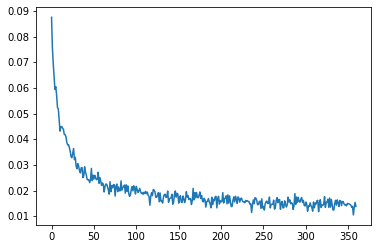

In [126]:
plt.plot(range(len(backprop_errors)), backprop_errors)

# Numpy version of MLP

In [1]:
import numpy as np
from lra_mlp import MLP, clip

def plot_flatten_image(flatten_image, image_height=28):
    plt.imshow(flatten_image.reshape((image_height, -1)))

inputs_v = train_images[0]
labels_v = train_labels[0]
mlp_test = MLP([784, 100, 100, 10])
for i in range(1000):
    mlp_test.lra_forward(inputs_v)
mlp_test.lra_step(labels_v, fdbk=True)
mlp_test.FA_step(labels_v)
plot_flatten_image(inputs_v.flatten())
clip(np.random.normal(0, 0.1, (2,2)), 0.1)

NameError: name 'train_images' is not defined

In [134]:

def one_hot(label, num_classes = 10):
    result = np.zeros(num_classes)
    result[label] = 1
    return result


def np_learn(nt: MLP, train_im, train_lb, epochs=3, optimizer = 'bp', errors_container = backprop_errors, **kwargs):
    step = 500
    upper_bound = train_im.shape[0]
    bar = tqdm(range(math.ceil(upper_bound*epochs/step)))
    spd = 0.01
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, inputs in enumerate(train_im, 0):

            labels = one_hot(train_lb[i])
            outputs = nt.forward(optimizer, inputs)
            nt.optim_step(optimizer, labels, spd=spd, **kwargs)

            loss = ((outputs - labels) ** 2).mean(axis=0)
            running_loss += loss

            if i % step == step-1:
                spd *= 0.995
                bar.update()
                mean_loss = running_loss / step
                errors_container.append(mean_loss)
                running_loss = 0.0

# Experiments

In [236]:
layers = [784, 16, 16, 10]
train_size = 100000
epochs = 3

In [237]:
backprop_errors = []
mlp = MLP(layers)
np_learn(
    mlp,
    train_images[:train_size],
    train_labels[:train_size],
    epochs=epochs,
    optimizer='bp',
    errors_container=backprop_errors
)

  0%|          | 0/360 [00:00<?, ?it/s]

In [141]:
lra_errors = []
mlp = MLP(layers)
np_learn(
    mlp,
    train_images[:train_size],
    train_labels[:train_size],
    epochs=epochs,
    optimizer='lra_diff',
    errors_container=lra_errors,
    iterations_num=2
)

  0%|          | 0/360 [00:00<?, ?it/s]

In [83]:
fdbk_errors = []
mlp = MLP(layers)
np_learn(
    mlp,
    train_images[:train_size],
    train_labels[:train_size],
    epochs=epochs,
    optimizer='lra_fdbk',
    errors_container=fdbk_errors
)

  0%|          | 0/360 [00:00<?, ?it/s]

In [238]:
FA_errors = []
mlp = MLP(layers)
np_learn(
    mlp,
    train_images[:train_size],
    train_labels[:train_size],
    epochs=epochs,
    optimizer='FA',
    errors_container=FA_errors
)


  0%|          | 0/360 [00:00<?, ?it/s]

In [244]:
random_matrix = np.random.normal(0, 0.1, (16, 784))
backprop_errors = []
randomed_data = np.zeros((60000, 16))
for i in range(60000):
    randomed_data[i] = random_matrix @ train_images[i]

test_layers = [16, 10]
test_mlp = MLP(test_layers)
np_learn(
    test_mlp,
    randomed_data[:train_size],
    train_labels[:train_size],
    epochs=epochs,
    optimizer='bp',
    errors_container=backprop_errors
)

  0%|          | 0/360 [00:00<?, ?it/s]

Text(0.5, 1.0, '3 layers')

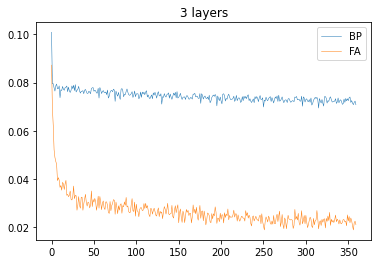

In [245]:
# plt.plot(range(len(adam_errors)), adam_errors,        label='torch.Adam', linewidth=0.5)
# plt.plot(range(len(sgd_errors)), sgd_errors,          label='torch.SGD',  linewidth=0.5)
plt.plot(range(len(backprop_errors)), backprop_errors,  label='BP',         linewidth=0.5)
# plt.plot(range(len(lra_errors)), lra_errors,            label='lra_diff',   linewidth=0.5)
# plt.plot(range(len(fdbk_errors)), fdbk_errors,          label='lra_fdbk',   linewidth=0.5)
plt.plot(range(len(FA_errors)), FA_errors,            label='FA',         linewidth=0.5)
plt.legend()
plt.title(f'{len(layers)-1} layers')